# Imports

# Neutron/Photon Separation
Can it be done???

In [2]:
import os
import sys
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

# Append source directory to path
sys.path.append("../../src/")

# Import custom modules
from ECALDataAnalyzer import ECALDataAnalyzer
from TrainData import load_zip_train_test_data, load_unzip_data
from model_functions import make_gravnet_model
from loss_functions import CustomLoss, AttractiveLossMetric, RepulsiveLossMetric, CowardLossMetric, NoiseLossMetric, LpLossMetric
from ModelEcalPlotter import ModelEcalPlotter
from Evaluator import Evaluator
from callbacks import PlotCallback, CyclicalLearningRate, LossPlotCallback
from helper_functions import create_output_directory, create_gif_from_pngs
from global_params import *
from model_functions import clip_out_beta
tf.config.list_physical_devices()

2024-10-10 00:14:41.929380: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-10 00:14:42.739841: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-10 00:14:43.400401: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-10 00:14:43.946366: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-10 00:14:44.090138: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-10 00:14:45.242951: I tensorflow/core/platform/cpu_feature_gu

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

# Load Data

In [3]:
batch_size = 128        # Batch size
project_directory = '../../projects/supercell.10.08.2024.18.28/training/'
(train_X, train_y, train_misc), (test_X, test_y, test_misc) = load_zip_train_test_data(project_directory, batch_size=batch_size, max_files=25)
train_data = tf.data.Dataset.zip((train_X, train_y))
test_data = tf.data.Dataset.zip((test_X, test_y))
h5file = "../../projects/supercell.10.08.2024.18.28/training/clasdispr.00.e10.600.emn0.75tmn.09.xs68.34nb.dis.0499.h5"
train_X,train_y,train_misc = load_unzip_data(h5file)
train_X=train_X[:batch_size]
train_y=train_y[:batch_size]
train_misc=train_misc[:batch_size]

np.unique(train_y[0,:,0])

array([-1.0000000e+00,  4.8163628e+07,  4.8163632e+07], dtype=float32)

In [5]:
# Set training parameters
initial_lr = 1e-5       # Initial learning rate for CLR
max_lr = 1e-4           # Maximum learning rate for CLR
step_size = 20          # 20 batches for half cycle, so 40 batches for a full cycle
N_epochs = 50           # Number of epochs to train
q_min = 0.1             # q_min for the custom loss
tB = 0.1                # Minimum beta for clustering
tD = 0.25               # Minimum distance for clustering
ev_n = 3                # Event numbers to plot
alpha_p = 0.0             # Hyperparameter for weighing loss
# Produce new output directory for saving plots
outdir = create_output_directory("./out")

# Define the model
model = make_gravnet_model(
    K=100,
    N_feat=28,
    N_grav_layers=6,
    N_neighbors=6,
    N_filters=64,
    use_sector=False
)

# Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_lr)

# Instantiate the custom loss function
custom_loss = CustomLoss(q_min=q_min, alpha_p=alpha_p)

# Compile the model with the new LpLossMetric
model.compile(
    optimizer=optimizer,
    loss=custom_loss,
    metrics=[
        AttractiveLossMetric(q_min=q_min),
        RepulsiveLossMetric(q_min=q_min),
        CowardLossMetric(q_min=q_min),
        NoiseLossMetric(q_min=q_min),
        LpLossMetric(alpha_p=alpha_p) 
    ]
)

# Callbacks
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True
)

clr_callback = CyclicalLearningRate(
    initial_learning_rate=initial_lr, 
    max_learning_rate=max_lr, 
    step_size=step_size
)

# # Extract train and test data for plotting
# for x in train_X.take(1):
#     ecal_x_train = x[0:0+ev_n]
#     break
# for y in train_y.take(1):
#     ecal_y_train = y[0:0+ev_n]
#     break
# for misc in train_misc.take(1):
#     ecal_misc_train= misc[0:0+ev_n]
#     break

# for x in test_X.take(1):
#     ecal_x_test = x[0:0+ev_n]
#     break
# for y in test_y.take(1):
#     ecal_y_test = y[0:0+ev_n]
#     break
# for misc in test_misc.take(1):
#     ecal_misc_test = misc[0:0+ev_n]
#     break

# # Plot callbacks for training and testing data
# ecal_train_plot_callback = PlotCallback(
#     X=ecal_x_train,
#     y=ecal_y_train,
#     misc=ecal_misc_train,
#     tB=tB,
#     tD=tD,
#     outdir=outdir,
#     version="train"
# )

# ecal_test_plot_callback = PlotCallback(
#     X=ecal_x_test,
#     y=ecal_y_test,
#     misc=ecal_misc_test,
#     tB=tB,
#     tD=tD,
#     outdir=outdir,
#     version="test"
# )

# Callback to plot loss metrics during training
loss_plot_callback = LossPlotCallback(
    save_dir=outdir
)

# Create checkpoint directory if it doesn't exist
os.makedirs(f'{outdir}/checkpoints',exist_ok=True)

# Checkpoint callback to save model at each epoch
checkpoint_callback = ModelCheckpoint(
    filepath=outdir+'/checkpoints/epoch_{epoch:02d}.keras',  # Save model to this file path, epoch will be part of the filename
    monitor='loss',                                       # You can monitor 'val_loss' or another metric if needed
    save_best_only=False,                                 # Set to True to save only the best model
    save_weights_only=False,                              # Set to True if you only want to save model weights
    save_freq='epoch',                                    # Save after every epoch
    verbose=0                                             # Print a message when the model is saved
)

# Output the number of parameters in the model
print("Number of Parameters:", model.count_params())

Number of Parameters: 134494


In [7]:
# Train the model
history = model.fit(train_X,
                    train_y,
                    batch_size=batch_size,
                    epochs=N_epochs,
                    shuffle=False,
                    #validation_data=test_data,
                    callbacks=[#early_stopping_callback,
                               clr_callback,
                               #ecal_train_plot_callback,
                               #ecal_test_plot_callback,
                               loss_plot_callback,
                               checkpoint_callback
                    ])

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - attractive_loss: 0.0404 - coward_loss: 0.4259 - loss: 1.0574 - lp_loss: 0.0000e+00 - noise_loss: 0.5000 - repulsive_loss: 0.0910
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - attractive_loss: 0.0394 - coward_loss: 0.4236 - loss: 1.0540 - lp_loss: 0.0000e+00 - noise_loss: 0.4994 - repulsive_loss: 0.0915
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - attractive_loss: 0.0414 - coward_loss: 0.4199 - loss: 1.0511 - lp_loss: 0.0000e+00 - noise_loss: 0.4985 - repulsive_loss: 0.0912
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - attractive_loss: 0.0407 - coward_loss: 0.4165 - loss: 1.0436 - lp_loss: 0.0000e+00 - noise_loss: 0.4974 - repulsive_loss: 0.0890
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - attractive_loss: 0.0420 - coward_loss: 0.4123 - loss: 1.0353 - lp_loss: 0.0000e+00 - noise_loss: 0.4960 - repulsive_loss: 0.0851
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - attractive_loss: 0.0431 - coward_loss: 0.406

KeyError: 'val_loss'

# Understanding why the Attractive Loss Fails after More Iterations

In [8]:
working_epoch = "10"

# 09_26_2024 Model 13 was run for a while originally
# 09_26_2024 Model 19 was run with the SUM OVER BATCH SIZE flag in the loss (bad-->100, good-->98ish)
def accumulate_batches(dataset, Nevents, batch_size=128):
    accumulated_data = []
    num_samples = 0
    # Iterate through the dataset to accumulate batches
    for batch in dataset:
        # If adding this batch would exceed Nevents, trim the batch
        if num_samples + len(batch) > Nevents:
            remaining_events = Nevents - num_samples
            accumulated_data.append(batch[:remaining_events])  # Take only the needed part of the batch
            num_samples += remaining_events
            break
        else:
            accumulated_data.append(batch)
            num_samples += len(batch)
        
        if num_samples >= Nevents:
            break
    
    # Concatenate all batches into a single array
    return np.concatenate(accumulated_data, axis=0)

def get_eval(epoch, tB=0.7, tD=0.3, Nevents=128, batch_size=128, version="train"):
    #model_load_path = "./out/10_09_2024_0045/checkpoints/epoch_499.keras"

    model_load_path = f"{outdir}/checkpoints/epoch_{epoch}.keras"
    model_load_path = f"./out/10_09_2024_0066/checkpoints/epoch_49.keras"
    # Load the model
    model = tf.keras.models.load_model(model_load_path, custom_objects={
        'CustomLoss': CustomLoss, 
        'AttractiveLossMetric': AttractiveLossMetric,
        'RepulsiveLossMetric': RepulsiveLossMetric,
        'CowardLossMetric': CowardLossMetric,
        'NoiseLossMetric': NoiseLossMetric,
        'LpLossMetric': LpLossMetric,
        'clip_out_beta': clip_out_beta
    })

    # Choose between training and testing datasets
    if version == "train":
        ecal_x = accumulate_batches(train_X, Nevents, batch_size)
        ecal_y = accumulate_batches(train_y, Nevents, batch_size)
        ecal_misc = accumulate_batches(train_misc, Nevents, batch_size)
    else:
        ecal_x = accumulate_batches(test_X, Nevents, batch_size)
        ecal_y = accumulate_batches(test_y, Nevents, batch_size)
        ecal_misc = accumulate_batches(test_misc, Nevents, batch_size)
    try:
    #evaluator = Evaluator('../../projects/flightb741.09.24.2024.20.53/training/clasdispr.00.e10.600.emn0.75tmn.09.xs68.34nb.dis.0000.h5', Nevents=10)
        evaluator = Evaluator(X=ecal_x,y=ecal_y,misc=ecal_misc)
        evaluator.load_model(model)
        evaluator.predict()
        evaluator.cluster(0.5,0.5)
    except:
        evaluator = Evaluator(h5file,Nevents=batch_size)
        evaluator.load_model(model)
        evaluator.predict()
        evaluator.cluster(0.5,0.5)
    return evaluator


working_eval = get_eval(working_epoch, Nevents=batch_size, batch_size=batch_size)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


100%|███████████████████████████████████████| 128/128 [00:00<00:00, 364.23it/s]


In [11]:
working_eval.get_event_dataframe().unique_otid

Randomly generated event number = 13235487


10300    48163652.0
10301    48163652.0
10302    48163648.0
10303    48163652.0
10304    48163652.0
            ...    
10395          -1.0
10396          -1.0
10397          -1.0
10398          -1.0
10399          -1.0
Name: unique_otid, Length: 100, dtype: float32

Working Loss Dictionary
 ****************************************************************************************************


event       1.323545e+07
n_objs      2.492188e+00
n_hits      1.000000e+02
att_loss    5.963057e-02
rep_loss    4.845892e-02
cow_loss    1.616610e-01
nse_loss    2.154909e-03
lp_loss     0.000000e+00
tot_loss    2.719055e-01
dtype: float64

,event,n_objs,n_hits,att_loss,rep_loss,cow_loss,nse_loss,lp_loss,tot_loss
0,13235383.0,3,100,0.043115,0.167231,0.178861,0.052318,0.0,0.441525
1,13235384.0,3,100,0.028853,0.202363,0.116802,0.000258,0.0,0.348276
2,13235385.0,3,100,0.074317,0.160227,0.154262,0.000258,0.0,0.389064
3,13235386.0,2,100,0.018724,0.000000,0.108310,0.000258,0.0,0.127292
4,13235388.0,3,100,0.035734,0.070754,0.182872,0.000258,0.0,0.289618
...,...,...,...,...,...,...,...,...,...
123,13235508.0,3,100,0.005749,0.103379,0.184618,0.000258,0.0,0.294005
124,13235509.0,2,100,0.037431,0.000000,0.086475,0.000258,0.0,0.124164
125,13235510.0,3,100,0.004424,0.085883,0.192938,0.000258,0.0,0.283503
126,13235511.0,2,100,0.111370,0.000000,0.185638,0.000258,0.0,0.297267


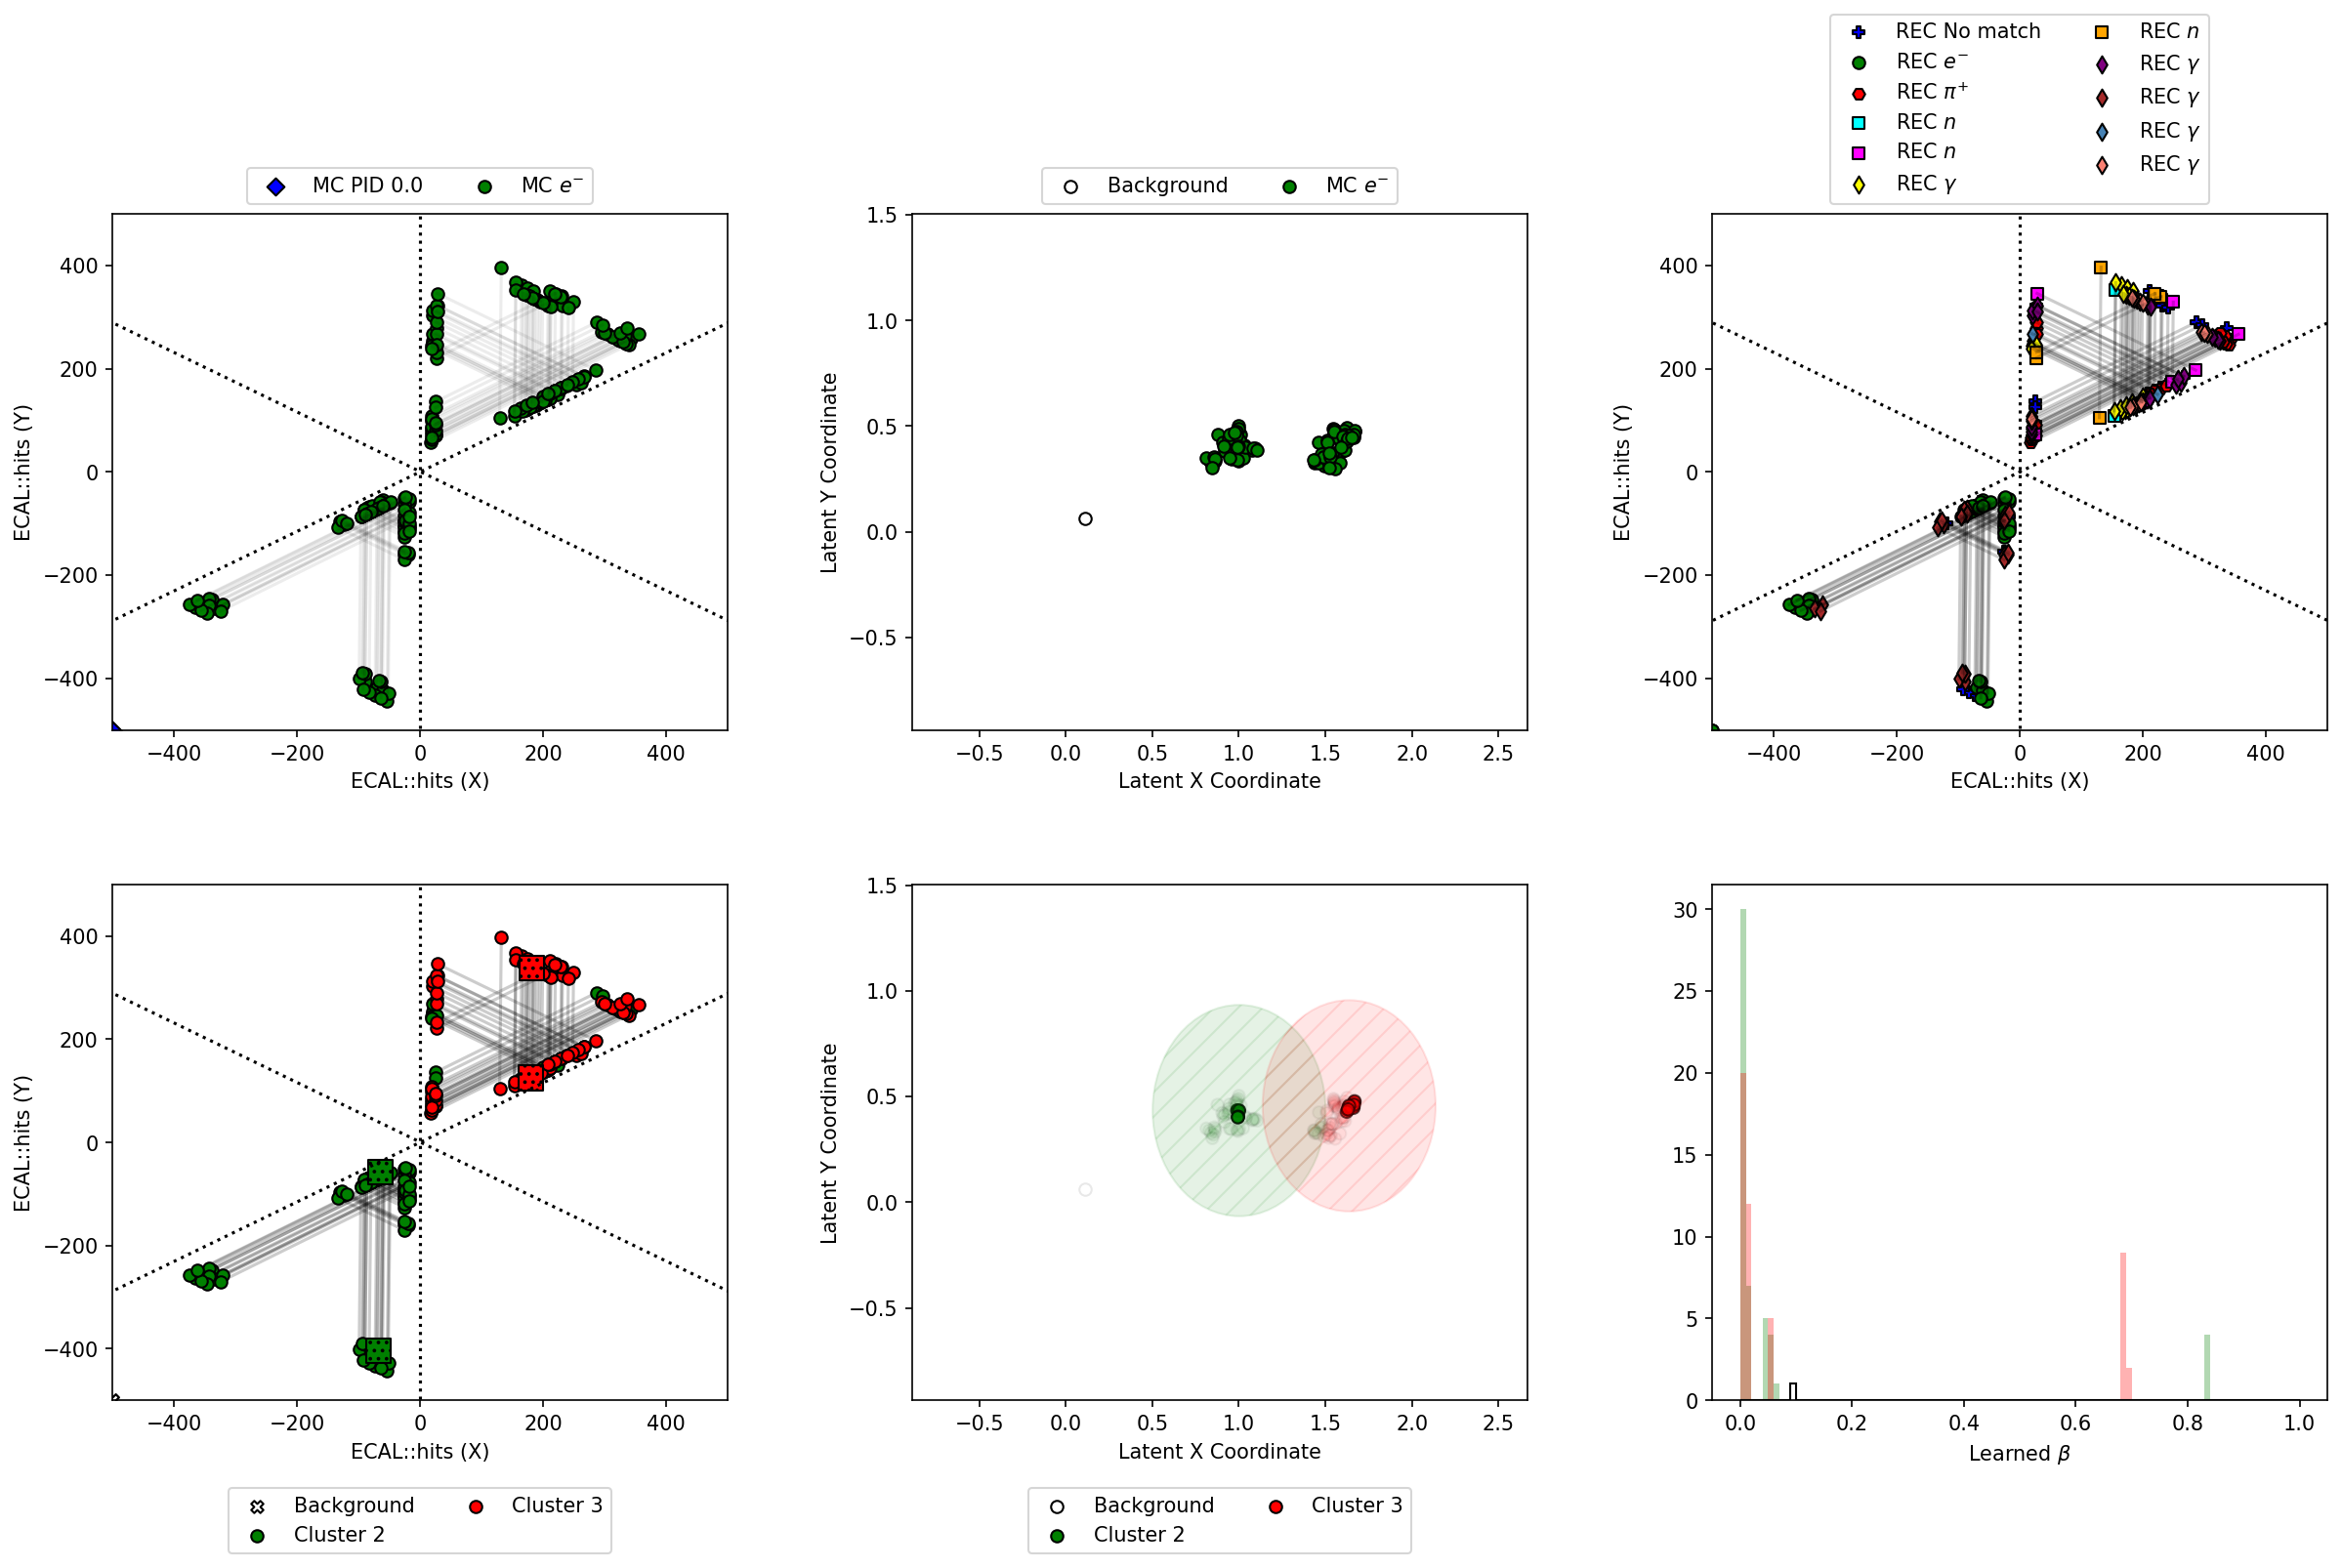

In [9]:
def plot(evaluator, ev):
    df = evaluator.get_event_dataframe(ev)
    plotter = ModelEcalPlotter(df,use_clas_calo_scale=True)
    plotter.plot_all(tD=evaluator.tD)


print("Working Loss Dictionary\n", "*" * 100)
working_loss_df = working_eval.get_loss_df(q_min=q_min,alpha_p=alpha_p)
display(working_loss_df.mean(), working_loss_df)
plot(working_eval, 120)


In [31]:
working_eval.get_event_dataframe(3).unique_otid.unique()

array([ 4.5653556e+07,  4.5653560e+07, -1.0000000e+00], dtype=float32)

In [ ]:
# Helper function to compute xi
def compute_xi_(beta, object_id, object_pid):
    """Compute xi = (1 - ni) * arctanh^2(beta)."""
    # n_i is 1 if:
    #  - object_id is not -1 (not background)
    #  - object_pid is not 2112 (neutron) or 22 (photon)
    is_background = tf.cast(object_id == -1, tf.float32)
    is_pid_2112_or_22 = tf.cast((object_pid == 2112) | (object_pid == 22), tf.float32)
    
    # n_i will be 1 for background and non-2112 or 22 particles
    n_i = tf.cast((tf.cast(is_background, tf.bool) | ~tf.cast(is_pid_2112_or_22, tf.bool)), tf.float32)
    #n_i = tf.cast((tf.cast(is_background, tf.bool)), tf.float32)
    
    # xi = (1 - n_i) * arctanh^2(beta)
    xi = (1 - n_i) * tf.math.atanh(beta)**2
    return xi

# Helper function to compute classification loss
def compute_classification_loss_(object_pid, prob_pid, f1=3.72, f2=15.87, f3=1.50):
    """Map object_pid to class indices, apply class weights, and compute the weighted cross-entropy classification loss."""
    
    # Map object_pid to class indices:
    # - class 0 for pid == 22 (photon)
    # - class 1 for pid == 2112 (neutron)
    # - class 2 for all other pids
    class_indices = tf.where(
        object_pid == 22, 0,  # If pid == 22, map to class 0
        tf.where(object_pid == 2112, 1, 2)  # If pid == 2112, map to class 1; else map to class 2
    )

    # Compute the sparse categorical cross-entropy loss
    classification_loss = tf.keras.losses.sparse_categorical_crossentropy(class_indices, prob_pid)

    # Define class weights
    class_weights = tf.where(
        class_indices == 0, f1,  # Apply weight f1 for class 0 (photon)
        tf.where(class_indices == 1, f2, f3)  # Apply weight f2 for class 1 (neutron), f3 for class 2 (others)
    )

    # Apply class weights to the loss
    weighted_loss = classification_loss * class_weights

    return weighted_loss
    
# Helper function to compute Lp_loss
def compute_Lp_loss_(object_id, beta, object_pid, prob_pid):
    """Compute Lp loss using the formula and weighted by xi."""
    xi = compute_xi_(beta, object_id, object_pid)
    classification_loss = compute_classification_loss_(object_pid, prob_pid)
    xi_sum = tf.reduce_sum(xi)
    if xi_sum==0:
        return xi_sum
    else:
        Lp_loss = tf.reduce_sum(classification_loss * xi) / xi_sum
        return Lp_loss

In [ ]:
ev = 127

model = tf.keras.models.load_model("./out/10_09_2024_0056/checkpoints/epoch_499.keras", custom_objects={
    'CustomLoss': CustomLoss, 
    'AttractiveLossMetric': AttractiveLossMetric,
    'RepulsiveLossMetric': RepulsiveLossMetric,
    'CowardLossMetric': CowardLossMetric,
    'NoiseLossMetric': NoiseLossMetric,
    'LpLossMetric': LpLossMetric,
    'clip_out_beta': clip_out_beta
})
y_pred = model.predict(train_X[ev:ev+1,:,:])
y_true = train_y[ev:ev+1,:,:]
prob_pid = y_pred[:, :, 3:6]
object_id = y_true[:, :, 0]
object_pid = y_true[:, :, 1]
beta = y_pred[:, :, 0]
lp_loss = alpha_p * compute_Lp_loss_(object_id, beta, object_pid, prob_pid)
print(f"lp_loss = a * Lp = {alpha_p} * {compute_Lp_loss(object_id, beta, object_pid, prob_pid)} = {lp_loss.numpy()}")

In [ ]:
lp_loss

In [ ]:
y_true = train_y[127:,:,:]